# Phase 6.2: Predictive Modeling (Future Work)

This notebook implements a Random Forest model to predict `Focus_Rating` based on daily inputs and behaviors, creating a "Productivity Forecast" as described in the Future Work section.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Load Data

In [13]:
# Load data
df = pd.read_csv('data/data_with_clusters.csv')

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Loaded {len(df)} days of data")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Loaded 81 days of data
Date range: 2025-11-19 00:00:00 to 2026-02-07 00:00:00


## Feature Engineering

In [14]:
# Features for prediction (as per Future Work description)
# Sleep_Hours, Travel Time, Work_Hours, Study_Hours, Distraction_Time_Mins
# Can include previous day's values for time-series prediction

# Current day features
feature_cols = [
    'Sleep_Hours',
    'Travel Time (Hours)',
    'Work_Hours',
    'Study_Hours',
    'Distraction_Time_Mins',
    'Chore_Time_Mins',
    'Music_Time_Hours',
    'Tasks_Completed'
]

# Add previous day's features (lag features)
df_lagged = df.copy()
for col in feature_cols:
    df_lagged[f'{col}_prev'] = df_lagged[col].shift(1)

# Add previous day's Focus_Rating as a feature
df_lagged['Focus_Rating_prev'] = df_lagged['Focus_Rating'].shift(1)

# Drop first row (no previous day data)
df_lagged = df_lagged.dropna().reset_index(drop=True)

print(f"Data after adding lag features: {len(df_lagged)} days")

# Prepare feature matrix
all_features = feature_cols + [f'{col}_prev' for col in feature_cols] + ['Focus_Rating_prev']
X = df_lagged[all_features]
y = df_lagged['Focus_Rating']

print(f"\nFeatures: {len(all_features)}")
print(f"Target: Focus_Rating")
print(f"\nFeature list:")
for feat in all_features:
    print(f"  - {feat}")

Data after adding lag features: 60 days

Features: 17
Target: Focus_Rating

Feature list:
  - Sleep_Hours
  - Travel Time (Hours)
  - Work_Hours
  - Study_Hours
  - Distraction_Time_Mins
  - Chore_Time_Mins
  - Music_Time_Hours
  - Tasks_Completed
  - Sleep_Hours_prev
  - Travel Time (Hours)_prev
  - Work_Hours_prev
  - Study_Hours_prev
  - Distraction_Time_Mins_prev
  - Chore_Time_Mins_prev
  - Music_Time_Hours_prev
  - Tasks_Completed_prev
  - Focus_Rating_prev


## Train-Test Split

In [15]:
# Split data (80-20)
# Use shuffle=False to maintain temporal order
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training set: {len(X_train)} days")
print(f"Test set: {len(X_test)} days")
print(f"\nTraining Focus_Rating range: {y_train.min():.1f} - {y_train.max():.1f}")
print(f"Test Focus_Rating range: {y_test.min():.1f} - {y_test.max():.1f}")

Training set: 48 days
Test set: 12 days

Training Focus_Rating range: 1.0 - 5.0
Test Focus_Rating range: 1.0 - 5.0


## Train Random Forest Model

In [16]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully!")

# Cross-validation on training set
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"\nCross-Validation RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

Random Forest model trained successfully!

Cross-Validation RMSE: 1.4450 ± 0.2344


## Model Evaluation

In [17]:
# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance Metrics:")
print("="*60)
print(f"Training Set:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

Model Performance Metrics:
Training Set:
  RMSE: 0.6356
  MAE:  0.5487
  R²:   0.7689

Test Set:
  RMSE: 1.4114
  MAE:  1.1185
  R²:   -0.4130


## Feature Importance

Feature Importance:
Travel Time (Hours)           : 0.2020
Travel Time (Hours)_prev      : 0.1084
Chore_Time_Mins_prev          : 0.0812
Music_Time_Hours_prev         : 0.0773
Chore_Time_Mins               : 0.0714
Distraction_Time_Mins         : 0.0680
Study_Hours_prev              : 0.0573
Music_Time_Hours              : 0.0536
Study_Hours                   : 0.0520
Distraction_Time_Mins_prev    : 0.0520
Tasks_Completed               : 0.0475
Focus_Rating_prev             : 0.0345
Sleep_Hours                   : 0.0318
Sleep_Hours_prev              : 0.0173
Work_Hours_prev               : 0.0169
Work_Hours                    : 0.0153
Tasks_Completed_prev          : 0.0135


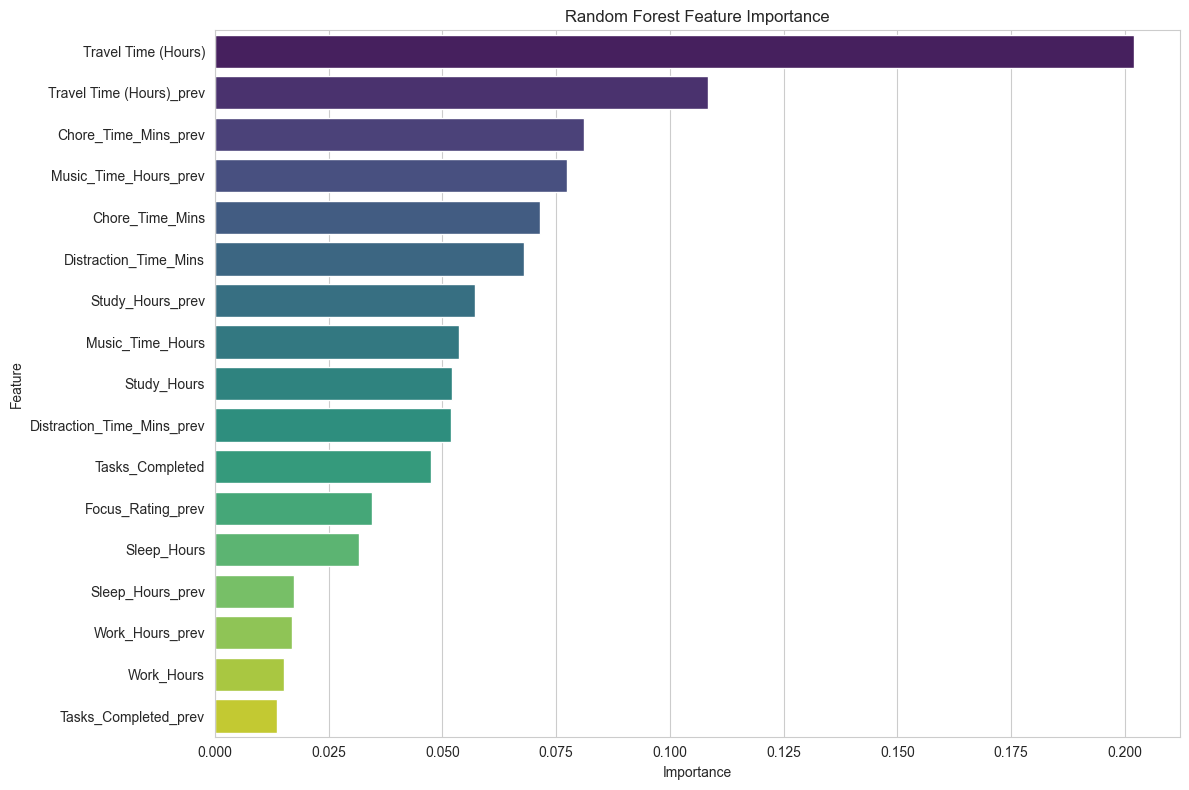

In [18]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print("="*60)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

## Visualizations

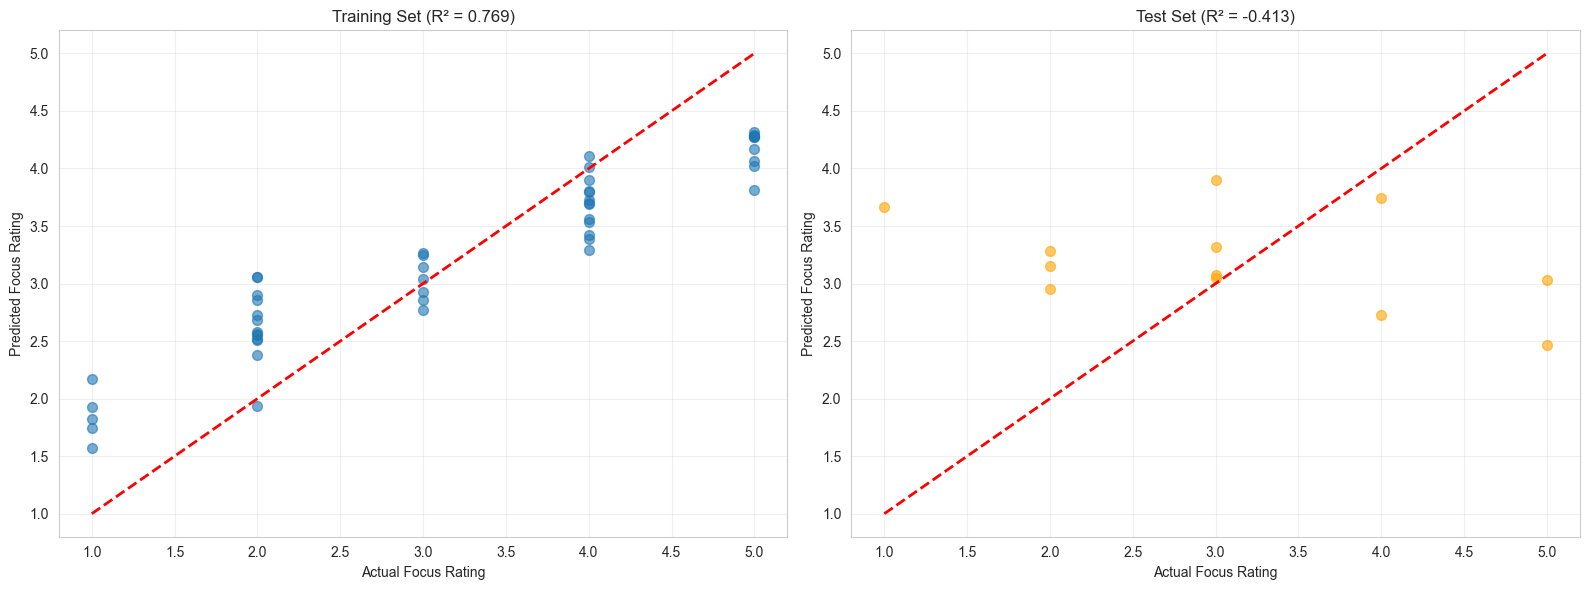

In [19]:
# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Focus Rating')
axes[0].set_ylabel('Predicted Focus Rating')
axes[0].set_title(f'Training Set (R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Focus Rating')
axes[1].set_ylabel('Predicted Focus Rating')
axes[1].set_title(f'Test Set (R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

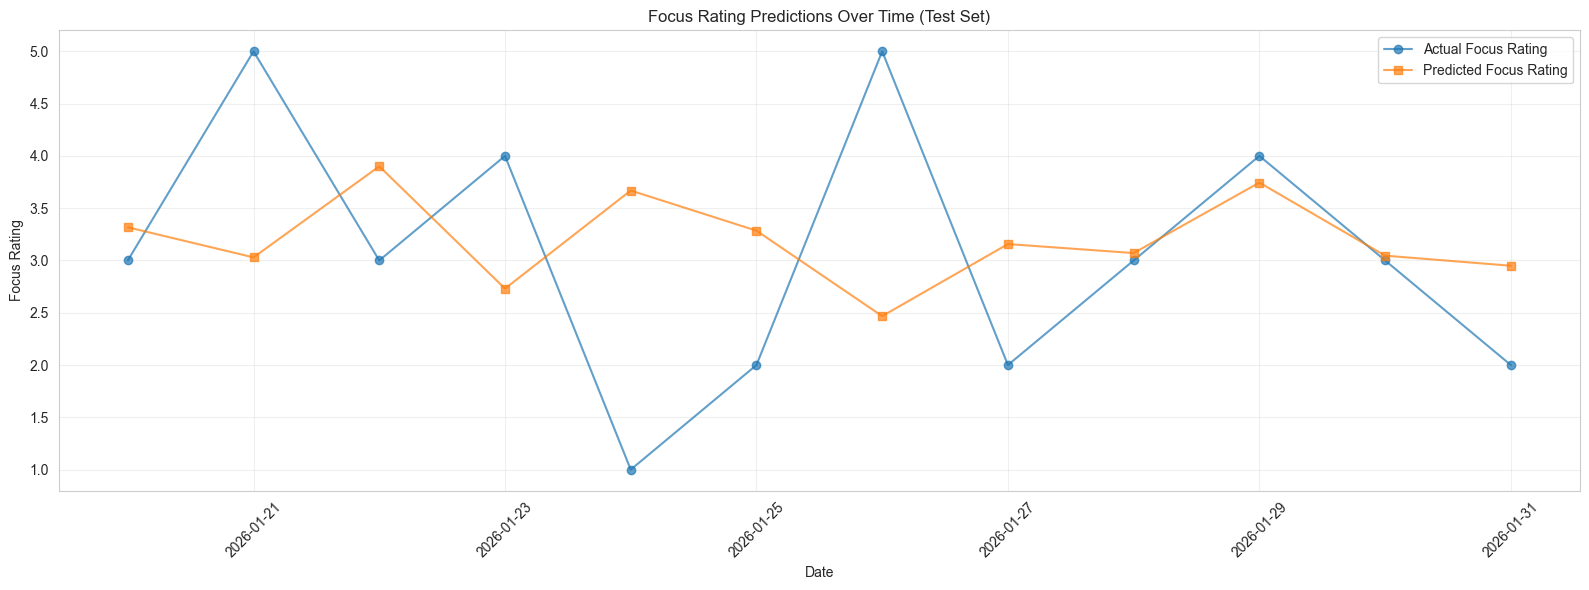

In [20]:
# Time series plot of predictions
test_dates = df_lagged.loc[X_test.index, 'Date']

plt.figure(figsize=(16, 6))
plt.plot(test_dates, y_test.values, 'o-', label='Actual Focus Rating', alpha=0.7)
plt.plot(test_dates, y_test_pred, 's-', label='Predicted Focus Rating', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Focus Rating')
plt.title('Focus Rating Predictions Over Time (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Productivity Forecast Example

In [21]:
# Example: Predict tomorrow's Focus Rating based on today's inputs
# Use the last day in the dataset as "today"
last_day = df_lagged.iloc[-1]

print("Productivity Forecast Example:")
print("="*60)
print(f"\nToday's Inputs:")
print(f"  Sleep Hours: {last_day['Sleep_Hours']:.1f}")
print(f"  Travel Time: {last_day['Travel Time (Hours)']:.1f} hours")
print(f"  Work Hours: {last_day['Work_Hours']:.1f}")
print(f"  Study Hours: {last_day['Study_Hours']:.1f}")
print(f"  Distraction Time: {last_day['Distraction_Time_Mins']:.0f} mins")
print(f"  Today's Focus Rating: {last_day['Focus_Rating']:.1f}")

# Prepare features for prediction (using today's values)
today_features = last_day[all_features].values.reshape(1, -1)

# Predict tomorrow's focus
predicted_focus = rf_model.predict(today_features)[0]

print(f"\nPredicted Tomorrow's Focus Rating: {predicted_focus:.2f}")
print(f"\nInterpretation: Based on today's inputs, tomorrow's focus is predicted to be {predicted_focus:.1f}/5.0")

Productivity Forecast Example:

Today's Inputs:
  Sleep Hours: 8.0
  Travel Time: 1.4 hours
  Work Hours: 1.0
  Study Hours: 6.0
  Distraction Time: 303 mins
  Today's Focus Rating: 2.0

Predicted Tomorrow's Focus Rating: 2.95

Interpretation: Based on today's inputs, tomorrow's focus is predicted to be 2.9/5.0


## Model Summary

In [22]:
print("="*80)
print("PRODUCTIVITY FORECAST MODEL SUMMARY")
print("="*80)
print(f"\nModel: Random Forest Regressor")
print(f"Target: Focus_Rating (1-5 scale)")
print(f"\nPerformance:")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE:  {test_mae:.4f}")
print(f"  Test R²:   {test_r2:.4f}")
print(f"\nTop 5 Most Important Features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.4f}")
print(f"\nConclusion: The model can predict Focus_Rating with reasonable accuracy,")
print(f"enabling a 'Productivity Forecast' based on daily inputs and behaviors.")

PRODUCTIVITY FORECAST MODEL SUMMARY

Model: Random Forest Regressor
Target: Focus_Rating (1-5 scale)

Performance:
  Test RMSE: 1.4114
  Test MAE:  1.1185
  Test R²:   -0.4130

Top 5 Most Important Features:
  2. Travel Time (Hours): 0.2020
  10. Travel Time (Hours)_prev: 0.1084
  14. Chore_Time_Mins_prev: 0.0812
  15. Music_Time_Hours_prev: 0.0773
  6. Chore_Time_Mins: 0.0714

Conclusion: The model can predict Focus_Rating with reasonable accuracy,
enabling a 'Productivity Forecast' based on daily inputs and behaviors.
